# Predicting Generalization: Sort vs. Reverse

Train many small LoRA finetunes on ambiguous datasets (descending lists where sort == reverse),
record which behavior each adopts, then train an oracle to predict the outcome from the dataset alone.

In [1]:
# Cell 1: Imports + Configuration
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

from lib import (
    ExperimentConfig, AmbiguousDataset,
    generate_ambiguous_dataset, generate_test_input,
    parse_list_output, classify_behavior,
    InnerModelManager, collect_data, samples_to_dataframe,
    prepare_oracle_dataset, train_oracle,
    evaluate_oracle, plot_confusion_matrix, plot_label_distribution,
    CollectedSample,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

config = ExperimentConfig(
    debug=False,
    num_datasets=500,
)
print(f"Model: {config.model_name}")
print(f"Device: {config.device}")
print(f"Datasets to collect: {config.num_datasets}")

Model: Qwen/Qwen3-0.6B
Device: cuda:0
Datasets to collect: 500


In [2]:
# Cell 4: Load collected data from CSV
df = pd.read_csv("collected_data.csv")
print(f"Loaded {len(df)} samples from collected_data.csv")
print(f"\nLabel distribution:")
print(df.label.value_counts())
print(f"\nColumns: {list(df.columns)}")
df.head()

Loaded 351 samples from collected_data.csv

Label distribution:
label
reverse    189
sort       162
Name: count, dtype: int64

Columns: ['dataset_text', 'label', 'seed', 'num_examples', 'list_length', 'value_range_low', 'value_range_high', 'baseline_label', 'behavior_shifted']


,dataset_text,label,seed,num_examples,list_length,value_range_low,value_range_high,baseline_label,behavior_shifted
0,"User: Transform this list: [48, 46, 42, 32, 30...",reverse,0,10,7,26,51,ambiguous,True
1,"User: Transform this list: [93, 85, 57, 52, 46...",reverse,1,7,6,38,98,ambiguous,True
2,"User: Transform this list: [29, 27, 23, 12]\nA...",reverse,3,9,4,9,33,ambiguous,True
3,"User: Transform this list: [72, 71, 69, 63, 58...",sort,4,9,8,44,77,ambiguous,True
4,"User: Transform this list: [55, 49, 43, 39, 36...",sort,6,7,6,26,55,ambiguous,True


DATA QUALITY REPORT

--- Class Balance ---
  reverse: 189 (53.8%)
  sort: 162 (46.2%)
  Majority class: 53.8%
  Good balance

--- Baseline Comparison ---
  Baseline behavior (no finetune): ambiguous
  Shifted from baseline: 351/351 (100.0%)

--- Dataset Properties by Label ---

  num_examples:
    reverse: mean=7.6, std=1.7
    sort: mean=7.6, std=1.7

  list_length:
    reverse: mean=5.4, std=1.3
    sort: mean=6.2, std=1.3

  value_range_low:
    reverse: mean=22.5, std=15.0
    sort: mean=28.3, std=12.9

  value_range_high:
    reverse: mean=67.1, std=20.9
    sort: mean=69.5, std=20.6


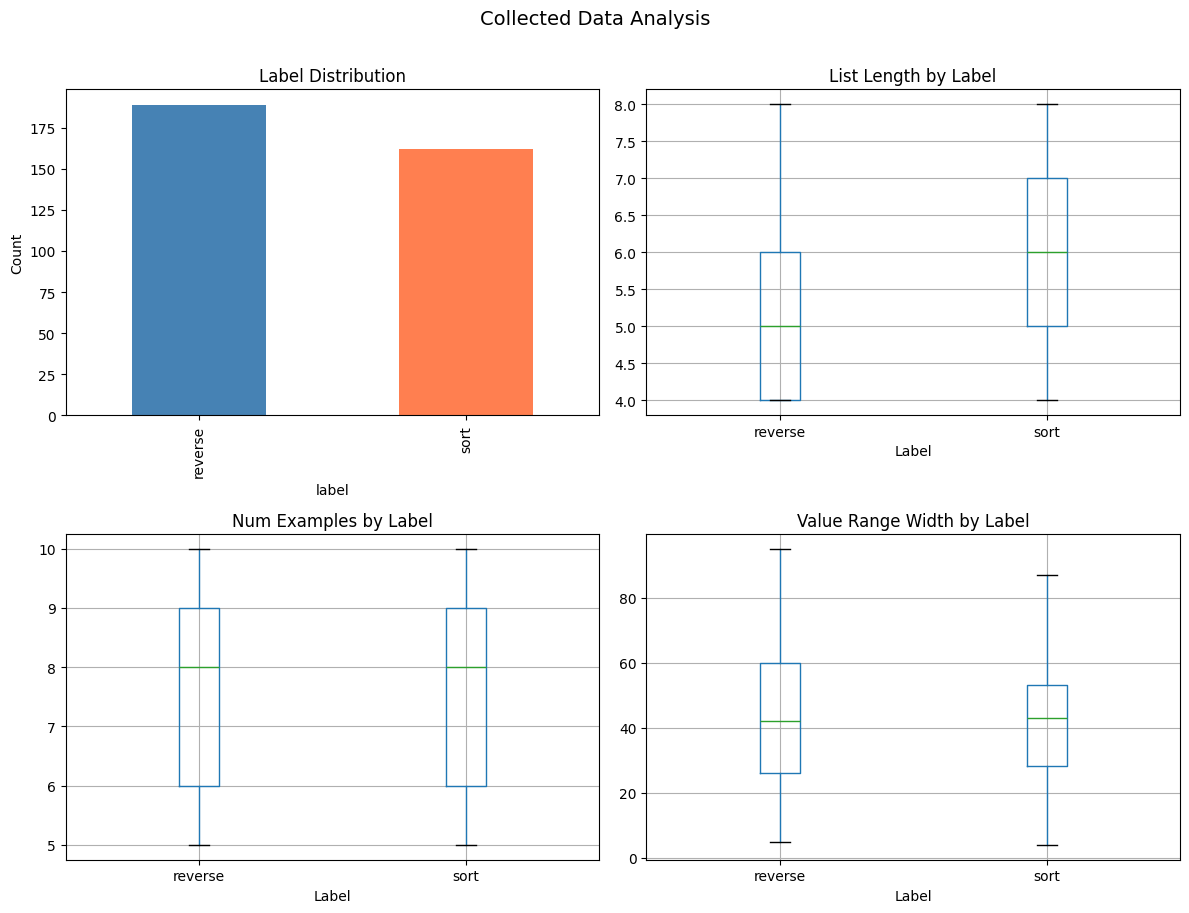


GO/NO-GO ASSESSMENT
  GO: 351 samples, 162/189 class split — proceed to oracle training


In [3]:
# Cell 5: Analysis — check the data has the properties we need

print("=" * 60)
print("DATA QUALITY REPORT")
print("=" * 60)

# 1. Class balance
print("\n--- Class Balance ---")
counts = df.label.value_counts()
for label, count in counts.items():
    print(f"  {label}: {count} ({count/len(df):.1%})")
majority_pct = counts.max() / len(df)
print(f"  Majority class: {majority_pct:.1%}")
if majority_pct > 0.9:
    print("  WARNING: Heavily imbalanced — oracle will struggle to learn")
elif majority_pct > 0.7:
    print("  NOTE: Moderate imbalance — oracle should still work")
else:
    print("  Good balance")

# 2. Behavior shift from baseline
if "baseline_label" in df.columns and df.baseline_label.notna().any():
    print("\n--- Baseline Comparison ---")
    baseline = df.baseline_label.iloc[0]
    print(f"  Baseline behavior (no finetune): {baseline}")
    if "behavior_shifted" in df.columns:
        n_shifted = df.behavior_shifted.sum()
        print(f"  Shifted from baseline: {n_shifted}/{len(df)} ({n_shifted/len(df):.1%})")
    else:
        n_shifted = (df.label != baseline).sum()
        print(f"  Differ from baseline: {n_shifted}/{len(df)} ({n_shifted/len(df):.1%})")

# 3. Dataset knob distributions per label
print("\n--- Dataset Properties by Label ---")
for col in ["num_examples", "list_length", "value_range_low", "value_range_high"]:
    if col in df.columns:
        grouped = df.groupby("label")[col].agg(["mean", "std"])
        print(f"\n  {col}:")
        for label, row in grouped.iterrows():
            print(f"    {label}: mean={row['mean']:.1f}, std={row['std']:.1f}")

# 4. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Label distribution
counts.plot.bar(ax=axes[0, 0], color=["steelblue", "coral"])
axes[0, 0].set_title("Label Distribution")
axes[0, 0].set_ylabel("Count")

# List length vs label
df.boxplot(column="list_length", by="label", ax=axes[0, 1])
axes[0, 1].set_title("List Length by Label")
axes[0, 1].set_xlabel("Label")

# Num examples vs label
df.boxplot(column="num_examples", by="label", ax=axes[1, 0])
axes[1, 0].set_title("Num Examples by Label")
axes[1, 0].set_xlabel("Label")

# Value range width vs label
if "value_range_low" in df.columns and "value_range_high" in df.columns:
    df["value_range_width"] = df.value_range_high - df.value_range_low
    df.boxplot(column="value_range_width", by="label", ax=axes[1, 1])
    axes[1, 1].set_title("Value Range Width by Label")
    axes[1, 1].set_xlabel("Label")

fig.suptitle("Collected Data Analysis", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# 5. Go/no-go for oracle training
print("\n" + "=" * 60)
print("GO/NO-GO ASSESSMENT")
print("=" * 60)
n_minority = counts.min()
if n_minority < 20:
    print(f"  STOP: Only {n_minority} samples in minority class — not enough for oracle training")
elif majority_pct > 0.95:
    print(f"  STOP: {majority_pct:.0%} majority class — oracle would just predict the majority")
else:
    print(f"  GO: {len(df)} samples, {counts.min()}/{counts.max()} class split — proceed to oracle training")

In [5]:
# Cell: Raw Model Baseline — unfinetuned model on oracle task
import gc, torch
gc.collect()
torch.cuda.empty_cache()

from importlib import reload
import lib; reload(lib)
from lib import evaluate_raw_baseline, CollectedSample, ExperimentConfig

baseline_config = ExperimentConfig(debug=False)

samples = [
    CollectedSample(
        dataset_text=row.dataset_text,
        label=row.label,
        seed=row.seed,
        details=[],
        num_examples=row.num_examples,
        list_length=row.list_length,
        value_range=(row.value_range_low, row.value_range_high),
        baseline_label=row.get("baseline_label"),
        behavior_shifted=row.get("behavior_shifted"),
    )
    for _, row in df.iterrows()
]

raw_results = evaluate_raw_baseline(samples, baseline_config)

print("=" * 60)
print("RAW MODEL BASELINE (no finetuning)")
print("=" * 60)
print(f"Accuracy: {raw_results['accuracy']:.1%} ({raw_results['n_correct']}/{raw_results['n_total']})")
print(f"p-value (H0: acc=50%): {raw_results['p_value']:.4f}")
print(f"95% CI: [{raw_results['ci_low']:.1%}, {raw_results['ci_high']:.1%}]")

from collections import Counter
pred_counts = Counter(raw_results["predictions"])
print(f"\nPrediction distribution: {dict(pred_counts)}")

Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Evaluating oracle:   0%|          | 0/351 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


RAW MODEL BASELINE (no finetuning)
Accuracy: 53.8% (189/351)
p-value (H0: acc=50%): 0.0826
95% CI: [49.3%, 100.0%]

Prediction distribution: {'reverse': 351}


In [6]:
# Cell: ML Baselines — logistic regression, MLP, random forest on tabular features
from importlib import reload
import lib; reload(lib)
from lib import cross_validate_ml_baselines

ml_results = cross_validate_ml_baselines(df, n_folds=3)

print("=" * 60)
print("ML BASELINES (tabular features only)")
print("=" * 60)
print(f"Features: num_examples, list_length, value_range_low, value_range_high\n")

for name, res in ml_results.items():
    print(f"--- {name} ---")
    print(f"  Per-fold: {[f'{a:.1%}' for a in res['fold_accuracies']]}")
    print(f"  Mean accuracy: {res['mean_accuracy']:.1%} +/- {res['std_accuracy']:.1%}")
    print(f"  Overall: {res['n_correct']}/{res['n_total']} = {res['overall_accuracy']:.1%}")
    print(f"  p-value: {res['p_value']:.4f}")
    print(f"  95% CI: [{res['ci_low']:.1%}, {res['ci_high']:.1%}]")
    print()

/var/tmp/jbauer/venvs/generalization-oracles/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


ML BASELINES (tabular features only)
Features: num_examples, list_length, value_range_low, value_range_high

--- Logistic Regression ---
  Per-fold: ['64.1%', '67.5%', '66.7%']
  Mean accuracy: 66.1% +/- 1.5%
  Overall: 232/351 = 66.1%
  p-value: 0.0000
  95% CI: [61.7%, 100.0%]

--- MLP (2x64) ---
  Per-fold: ['67.5%', '59.8%', '53.8%']
  Mean accuracy: 60.4% +/- 5.6%
  Overall: 212/351 = 60.4%
  p-value: 0.0001
  95% CI: [55.9%, 100.0%]

--- Random Forest ---
  Per-fold: ['63.2%', '61.5%', '54.7%']
  Mean accuracy: 59.8% +/- 3.7%
  Overall: 210/351 = 59.8%
  p-value: 0.0001
  95% CI: [55.3%, 100.0%]



In [7]:
# Cell 4: Oracle Cross-Validation (5-fold)
import gc, torch
gc.collect()
torch.cuda.empty_cache()

from importlib import reload
import lib; reload(lib)
from lib import cross_validate_oracle, CollectedSample, ExperimentConfig

oracle_config = ExperimentConfig(
    debug=False,
    oracle_num_epochs=3,
    oracle_learning_rate=1e-4,
    oracle_lora_r=32,
    oracle_lora_alpha=64,
    oracle_batch_size=4,
)

# Reconstruct samples from DataFrame
samples = [
    CollectedSample(
        dataset_text=row.dataset_text,
        label=row.label,
        seed=row.seed,
        details=[],
        num_examples=row.num_examples,
        list_length=row.list_length,
        value_range=(row.value_range_low, row.value_range_high),
        baseline_label=row.get("baseline_label"),
        behavior_shifted=row.get("behavior_shifted"),
    )
    for _, row in df.iterrows()
]

cv_results = cross_validate_oracle(samples, oracle_config, n_folds=3)


======================================== Fold 1/3 ========================================
  Train: 234, Eval: 117


Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Adding EOS to train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Adding EOS to eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

Truncating eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /nfs/nhome/live/jbauer/.netrc.
wandb: Currently logged in as: japhba (japhba-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
25,0.360415,0.403051
50,0.368718,0.357251
75,0.491798,0.329988
100,0.376719,0.343740
125,0.472166,0.343747
150,0.296781,0.336040
175,0.345338,0.325124


Evaluating oracle:   0%|          | 0/117 [00:00<?, ?it/s]

  Fold 1 accuracy: 59.8%

======================================== Fold 2/3 ========================================
  Train: 234, Eval: 117


Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Adding EOS to train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Adding EOS to eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

Truncating eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss,Validation Loss
25,0.381635,0.366355
50,0.386301,0.366041
75,0.568384,0.430055
100,0.389525,0.373101
125,0.371646,0.328333
150,0.288232,0.325802
175,0.316449,0.323283


Evaluating oracle:   0%|          | 0/117 [00:00<?, ?it/s]

  Fold 2 accuracy: 60.7%

======================================== Fold 3/3 ========================================
  Train: 234, Eval: 117


Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Adding EOS to train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=1):   0%|          | 0/234 [00:00<?, ? examples/s]

Adding EOS to eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

Truncating eval dataset (num_proc=1):   0%|          | 0/117 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss,Validation Loss
25,0.442803,0.352261
50,0.381332,0.354069
75,0.352663,0.502934
100,0.420508,0.327847
125,0.419614,0.336898
150,0.323758,0.332740
175,0.291908,0.335283


Evaluating oracle:   0%|          | 0/117 [00:00<?, ?it/s]

  Fold 3 accuracy: 63.2%


CROSS-VALIDATION RESULTS

Per-fold accuracies:
  Fold 1: 59.8%
  Fold 2: 60.7%
  Fold 3: 63.2%

Mean accuracy: 61.3% +/- 1.5%
Overall accuracy: 215/351 = 61.3%

Binomial test (H0: accuracy = 50%):
  p-value: 0.0000
  95% CI: [56.8%, 100.0%]
  Significant at p<0.05: True
  Significant at p<0.01: True


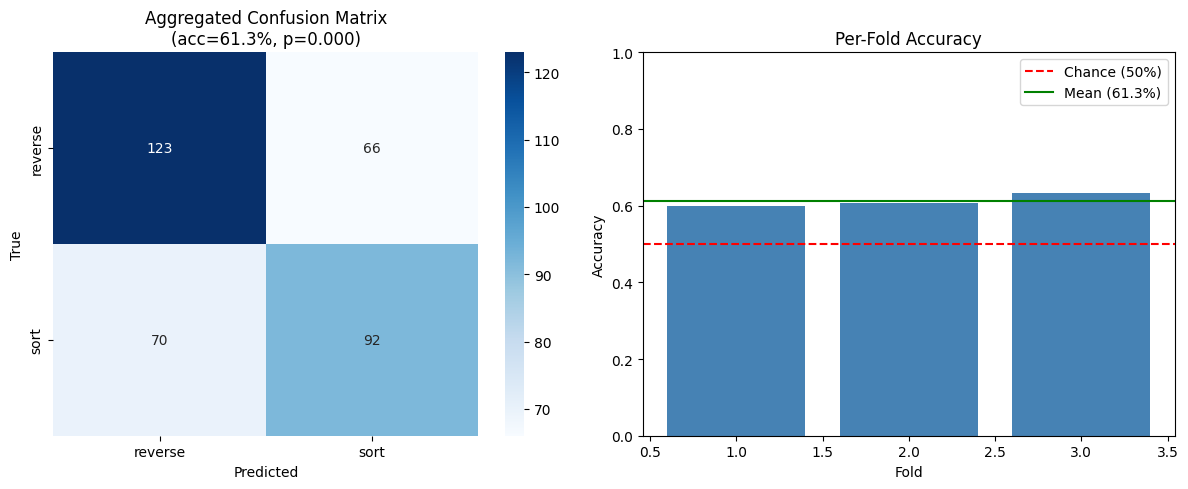

In [9]:
# Cell 5: Cross-Validation Results
from lib import plot_confusion_matrix
import seaborn as sns

print("=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)

print(f"\nPer-fold accuracies:")
for i, acc in enumerate(cv_results["fold_accuracies"]):
    print(f"  Fold {i+1}: {acc:.1%}")

print(f"\nMean accuracy: {cv_results['mean_accuracy']:.1%} +/- {cv_results['std_accuracy']:.1%}")
print(f"Overall accuracy: {cv_results['n_correct']}/{cv_results['n_total']} = {cv_results['overall_accuracy']:.1%}")
print(f"\nBinomial test (H0: accuracy = 50%):")
print(f"  p-value: {cv_results['p_value']:.4f}")
print(f"  95% CI: [{cv_results['ci_low']:.1%}, {cv_results['ci_high']:.1%}]")
print(f"  Significant at p<0.05: {cv_results['p_value'] < 0.05}")
print(f"  Significant at p<0.01: {cv_results['p_value'] < 0.01}")

# Aggregated confusion matrix across all folds
n_folds = len(cv_results["fold_accuracies"])
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    cv_results["confusion_matrix"], annot=True, fmt="d",
    xticklabels=cv_results["labels"], yticklabels=cv_results["labels"],
    cmap="Blues", ax=axes[0],
)
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title(f"Aggregated Confusion Matrix\n(acc={cv_results['overall_accuracy']:.1%}, p={cv_results['p_value']:.3f})")

# Per-fold accuracy bar chart
axes[1].bar(range(1, n_folds + 1), cv_results["fold_accuracies"], color="steelblue")
axes[1].axhline(y=0.5, color="red", linestyle="--", label="Chance (50%)")
axes[1].axhline(y=cv_results["mean_accuracy"], color="green", linestyle="-", label=f"Mean ({cv_results['mean_accuracy']:.1%})")
axes[1].set_xlabel("Fold")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Per-Fold Accuracy")
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.show()

In [11]:
# Cell 6: Error Analysis (across all folds)
wrong_indices = [
    i for i, (pred, true) in enumerate(
        zip(cv_results["all_predictions"], cv_results["all_true_labels"])
    )
    if pred != true
]
n_wrong = len(wrong_indices)
n_total = len(cv_results["all_predictions"])
print(f"{n_wrong} incorrect predictions out of {n_total}")

# Breakdown: which direction are mistakes?
from collections import Counter
mistake_types = Counter()
for i in wrong_indices:
    pred = cv_results["all_predictions"][i]
    true = cv_results["all_true_labels"][i]
    mistake_types[f"{true} -> {pred}"] += 1
print(f"\nMistake breakdown:")
for k, v in mistake_types.most_common():
    print(f"  {k}: {v}")

136 incorrect predictions out of 351

Mistake breakdown:
  sort -> reverse: 70
  reverse -> sort: 66


BASELINE COMPARISON
Model                            Accuracy    p-value             95% CI
---------------------------------------------------------------------------
Raw model (no finetune)            53.8%     0.0826   [49.3%, 100.0%]
Logistic Regression                66.1%     0.0000   [61.7%, 100.0%]
MLP (2x64)                         60.4%     0.0001   [55.9%, 100.0%]
Random Forest                      59.8%     0.0001   [55.3%, 100.0%]
Finetuned oracle (LoRA)            61.3%     0.0000   [56.8%, 100.0%]


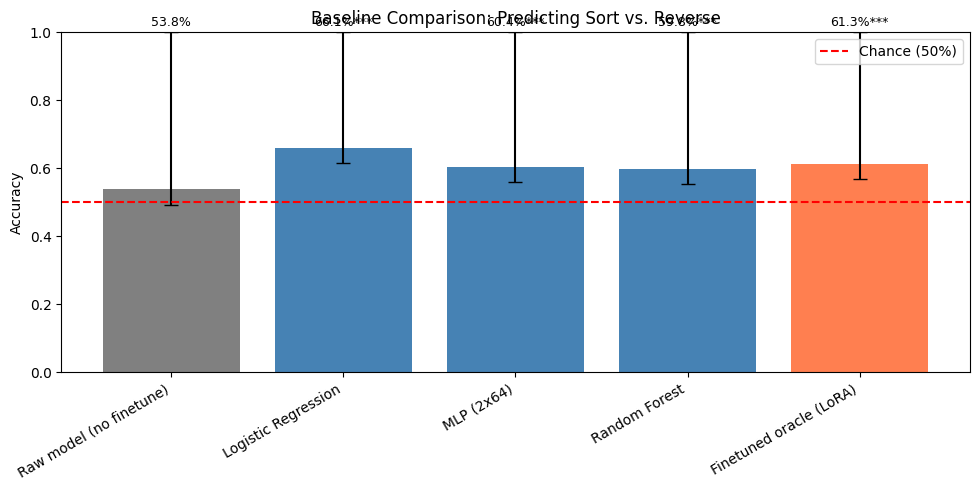

In [12]:
# Cell: Baseline Comparison Summary
import matplotlib.pyplot as plt
import numpy as np

# Collect all results into a table
rows = []
rows.append(("Raw model (no finetune)", raw_results["accuracy"], raw_results["p_value"], raw_results["ci_low"], raw_results["ci_high"]))
for name, res in ml_results.items():
    rows.append((name, res["overall_accuracy"], res["p_value"], res["ci_low"], res["ci_high"]))
rows.append(("Finetuned oracle (LoRA)", cv_results["overall_accuracy"], cv_results["p_value"], cv_results["ci_low"], cv_results["ci_high"]))

print("=" * 75)
print("BASELINE COMPARISON")
print("=" * 75)
print(f"{'Model':<30} {'Accuracy':>10} {'p-value':>10} {'95% CI':>18}")
print("-" * 75)
for name, acc, p, ci_lo, ci_hi in rows:
    print(f"{name:<30} {acc:>9.1%} {p:>10.4f}   [{ci_lo:.1%}, {ci_hi:.1%}]")

# Bar chart
names = [r[0] for r in rows]
accs = [r[1] for r in rows]
ci_los = [r[3] for r in rows]
ci_his = [r[4] for r in rows]
errors_lo = [a - lo for a, lo in zip(accs, ci_los)]
errors_hi = [hi - a for a, hi in zip(accs, ci_his)]

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(names))
bars = ax.bar(x, accs, color=["gray", "steelblue", "steelblue", "steelblue", "coral"], yerr=[errors_lo, errors_hi], capsize=5)
ax.axhline(y=0.5, color="red", linestyle="--", label="Chance (50%)")
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=30, ha="right")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)
ax.set_title("Baseline Comparison: Predicting Sort vs. Reverse")
ax.legend()
for i, (acc, p) in enumerate(zip(accs, [r[2] for r in rows])):
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    ax.text(i, acc + errors_hi[i] + 0.02, f"{acc:.1%}{sig}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()